In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv("glove_emg1.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,0,-1,-5,-4,3,7,3,1,0,1,2,3,4
1,0,-3,0,2,-3,1,0,0,0,1,2,3,4
2,-2,-2,-2,-3,-4,-9,-4,-2,0,1,2,3,4
3,-1,0,-4,-2,1,0,0,-1,0,1,2,3,4
4,1,3,6,1,2,-1,-1,-2,0,1,2,3,4


<AxesSubplot:>

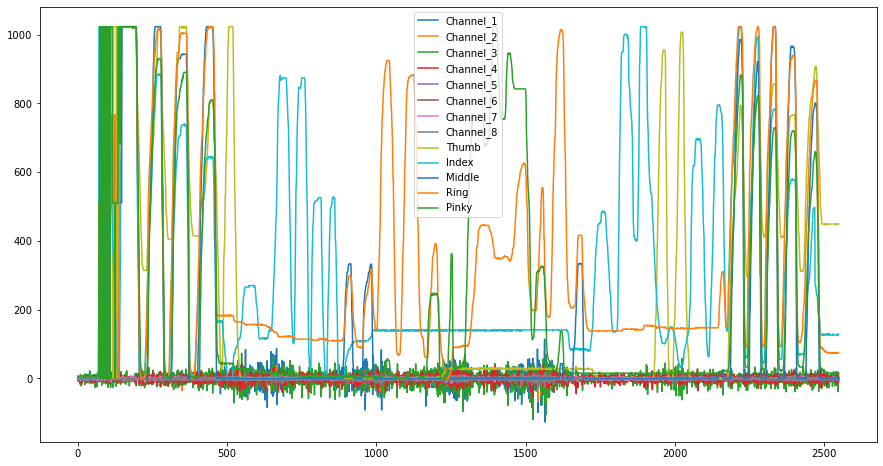

In [4]:
plt.rc('figure', figsize=(15, 8))

data.plot(figsize=(15, 8))

In [5]:
data.var()

Channel_1       231.422691
Channel_2        62.678778
Channel_3       339.070190
Channel_4       101.594115
Channel_5        12.859527
Channel_6        12.435296
Channel_7         8.450300
Channel_8        11.675062
Thumb        115775.031467
Index         87236.618187
Middle        95768.315449
Ring          95813.086940
Pinky        109602.896781
dtype: float64

In [6]:
df = data.copy()

# Get rid of garbage data.
df = df.tail(2300)

[Text(0.5, 1.0, 'sEMG and Leap corrolations')]

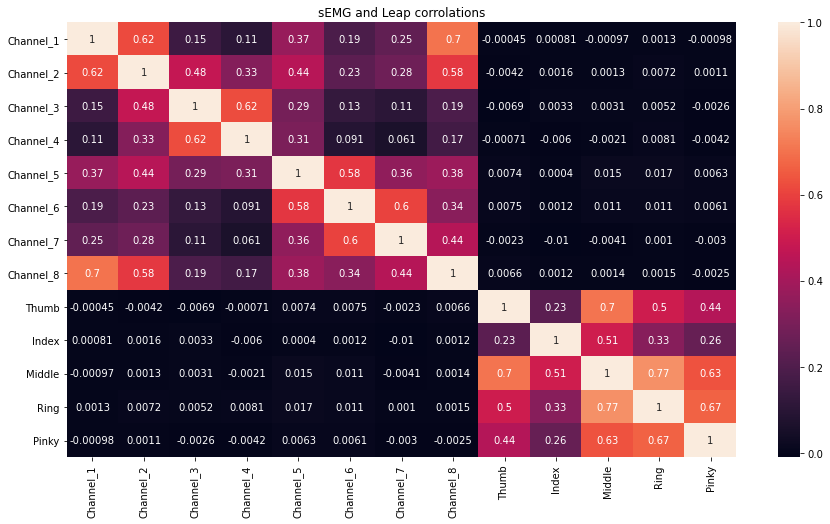

In [7]:
sns.heatmap(df.corr(), annot=True).set(title="sEMG and Leap corrolations")

# Feature engineering: relative positions

[Text(0.5, 1.0, 'sEMG and Leap rel corrolations')]

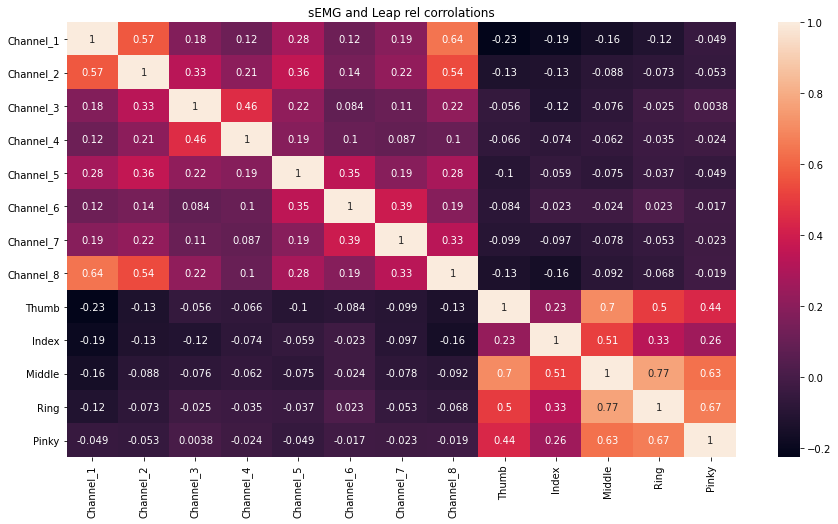

In [8]:
df_rel = abs(df)

sns.heatmap(df_rel.corr(), annot=True).set(title="sEMG and Leap rel corrolations")

# Preprocessing

<AxesSubplot:>

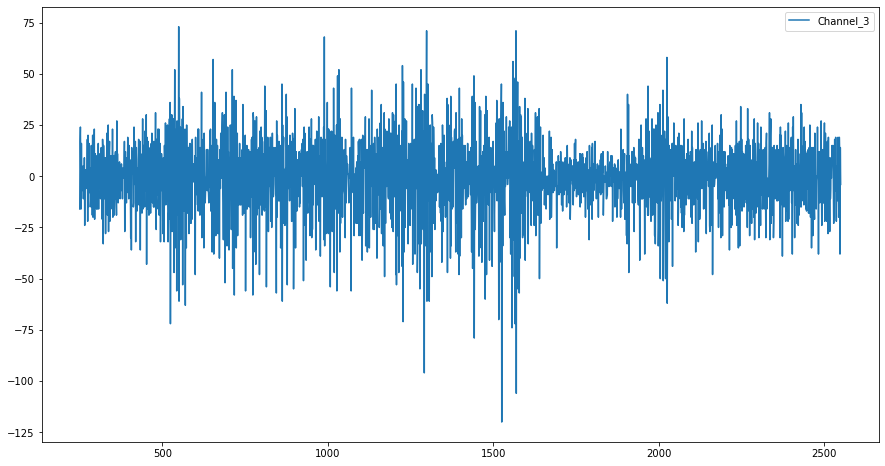

In [9]:
rr3 = df[['Channel_3']]
rr3.plot()

<AxesSubplot:>

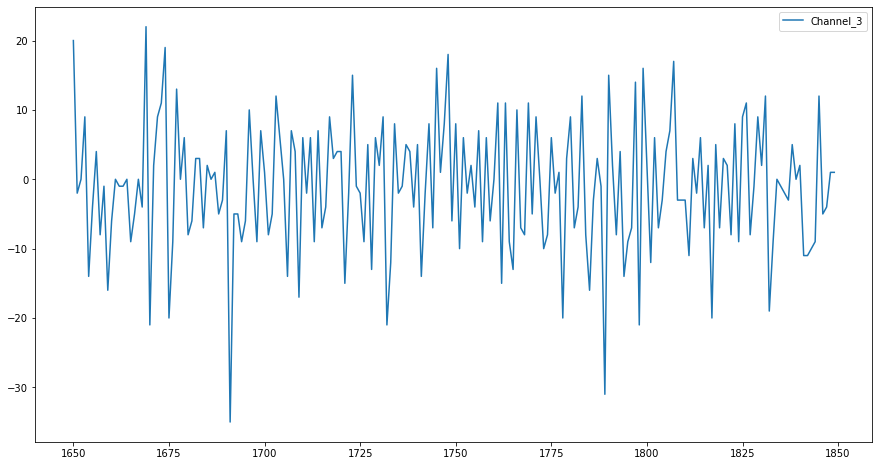

In [10]:
rr3[1400:1600].plot()

# High Pass Filter

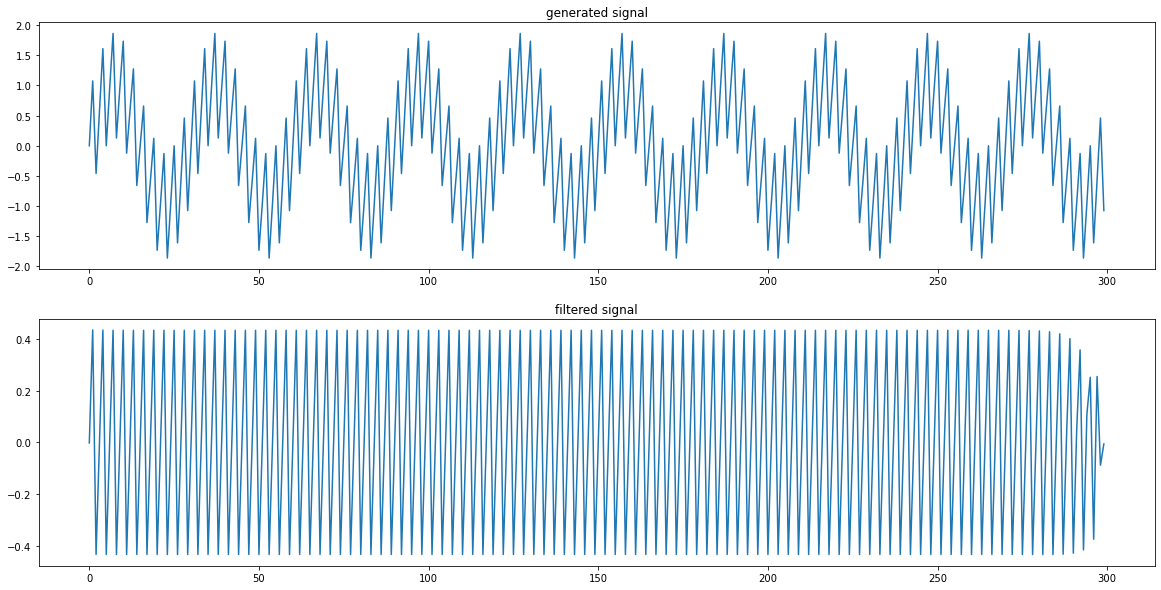

In [11]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

def sine_generator(fs, sinefreq, duration):
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)
    result = pd.DataFrame({ 
        'data' : y_sine} ,index=t_sine)
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

fps = 30
sine_fq = 10 #Hz
duration = 10 #seconds
sine_5Hz = sine_generator(fps,sine_fq,duration)
sine_fq = 1 #Hz
duration = 10 #seconds
sine_1Hz = sine_generator(fps,sine_fq,duration)

sine = sine_5Hz + sine_1Hz

filtered_sine = butter_highpass_filter(sine.data,10,fps)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(range(len(sine)),sine)
plt.title('generated signal')
plt.subplot(212)
plt.plot(range(len(filtered_sine)),filtered_sine)
plt.title('filtered signal')
plt.show()

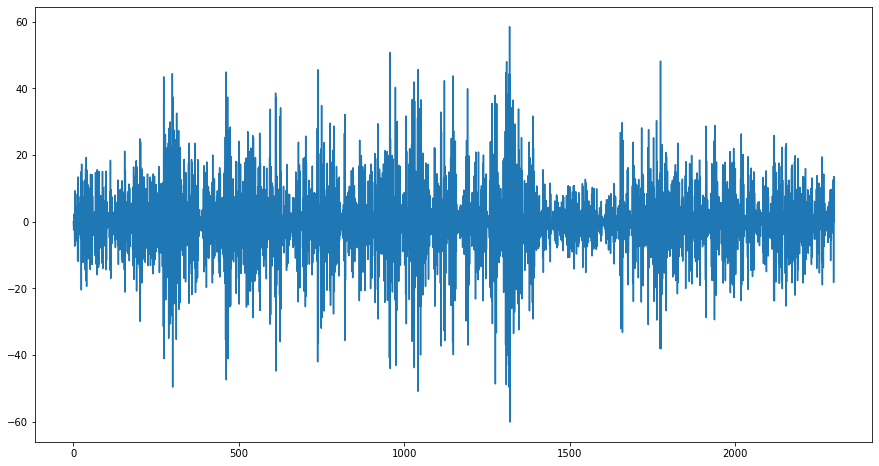

In [12]:
filtered_sine = butter_highpass_filter(rr3['Channel_3'],10,fps)

plt.plot(range(len(filtered_sine)),filtered_sine)

In [13]:
df = pd.read_csv("glove_emg1.csv")
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

# Get rid of garbage data.
df = df.tail(2300)

# Rectify
df = abs(df)

# High Pass Filter
fps = 30
for col in myo_cols:
    channel = df[col]
    filtered_channel = butter_highpass_filter(channel,10,fps)
    df[col] = abs(filtered_channel)


[Text(0.5, 1.0, 'sEMG and Glove corrolations')]

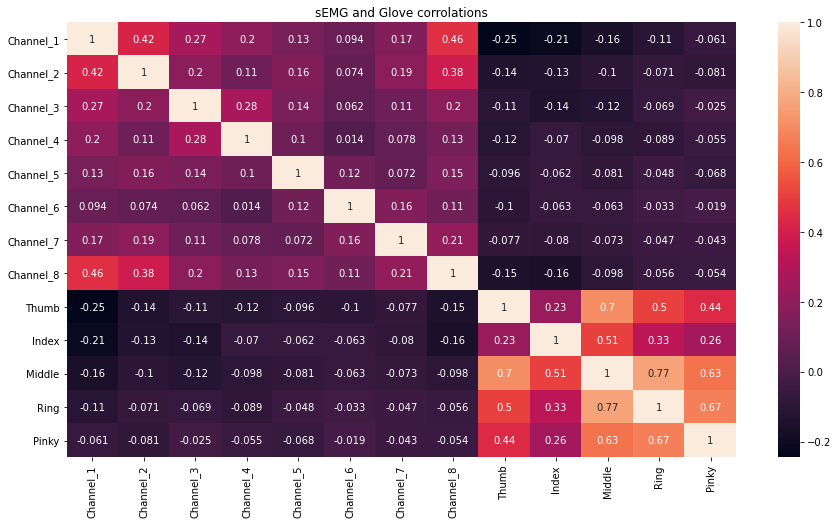

In [14]:
sns.heatmap(df.corr(), annot=True).set(title="sEMG and Glove corrolations")

# Low Pass Filter

A low pass filter attenuates signals with frequencies higher than the cut off frequency.   
The 0x03 data set from the Myo has a lot of high frequency noise which often results in low sEMG data being sent when the muscles are contracted. 

Note that after data has been though a low pass filter, the rate needed to sample this data and recreate it changes, this is why mode 0x01 sends data at 50Hz, instead of the 200Hz the Myo uses otherwise. 

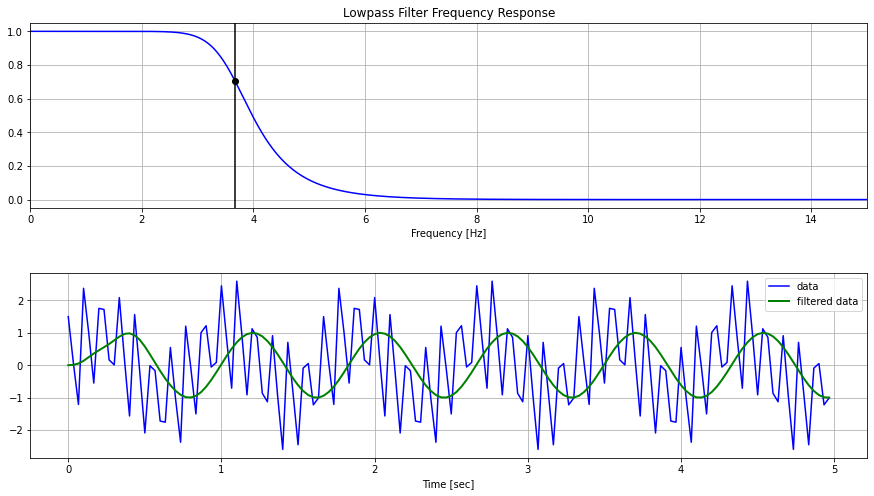

In [15]:
'''
https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
'''
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

<ipython-input-16-d7ce4cc69d02>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr3['Filtered'] = filtered_rr3


Text(0.5, 1.0, 'Lowpass filtered')

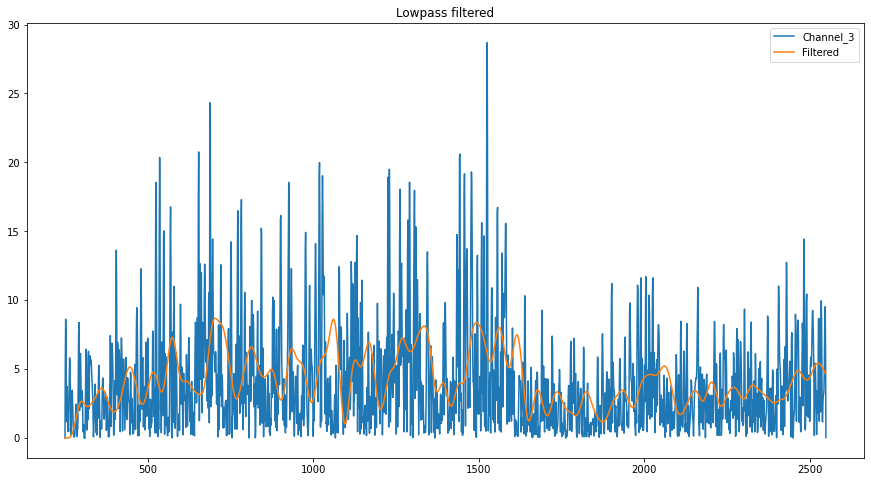

In [16]:
# Filter requirements.
order = 6
fs = 200.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

rr3 = df[['Channel_3']]
filtered_rr3 = butter_lowpass_filter(rr3['Channel_3'], cutoff, fs, order)

rr3['Filtered'] = filtered_rr3

rr3.plot()
plt.title('Lowpass filtered')

In [17]:
df = pd.read_csv("glove_emg1.csv")
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

# Get rid of garbage data.
df = df.tail(2300)

# Rectify
df = abs(df)

# Low Pass Filter
# Filter requirements.
order = 6
fs = 200.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

for col in myo_cols:
    channel = df[col]
    filtered_channel = butter_lowpass_filter(channel, cutoff, fs, order)
    df[col] = abs(filtered_channel)


[Text(0.5, 1.0, 'sEMG and Glove corrolations')]

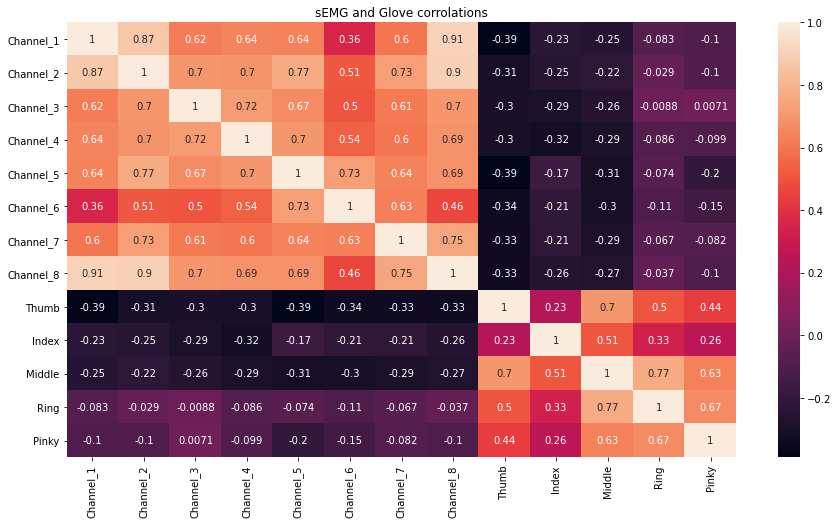

In [18]:
sns.heatmap(df.corr(), annot=True).set(title="sEMG and Glove corrolations")

[Text(0.5, 1.0, 'sEMG and Glove corrolations')]

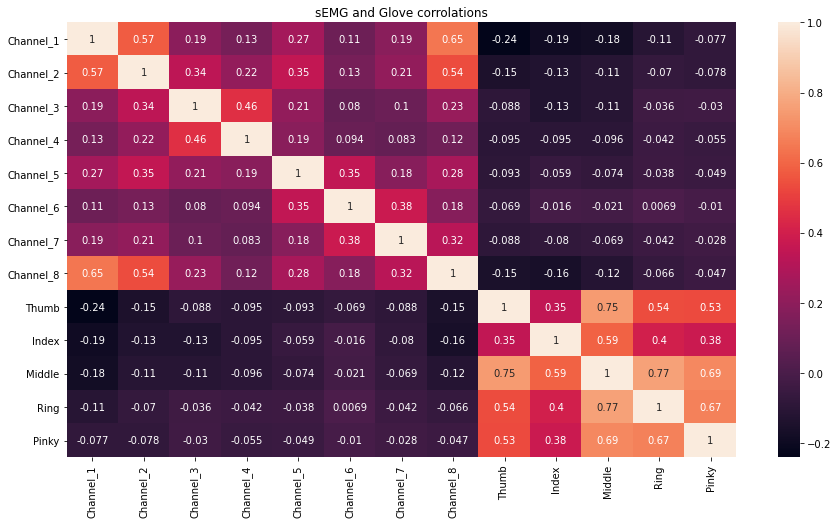

In [19]:
data = pd.read_csv("glove_emg1.csv")
abs_data = abs(data)
sns.heatmap(abs_data.corr(), annot=True).set(title="sEMG and Glove corrolations")

# Making a full hand baseline

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = df[x_cols]
y = df.drop(x_cols,1)

train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

# Making our benchmark model
# Just predict the mean average number of bikes. 
y_train_mean = train_y.mean()

train_preds = np.ones(train_y.shape) * y_train_mean
preds = np.ones(test_y.shape) * y_train_mean

rmse = np.sqrt(mean_squared_error(train_y, train_preds))
print("Train RMSE: %f" % (rmse))

mae = mean_absolute_error(train_y, train_preds)
print("Train MAE: %f" % (mae))

rmse = np.sqrt(mean_squared_error(test_y, preds))
print("Test RMSE: %f" % (rmse))

mae = mean_absolute_error(test_y, preds)
print("Test MAE: %f" % (mae))

r2_score(test_y, preds)

Train RMSE: 303.260042
Train MAE: 245.206529
Test RMSE: 299.045560
Test MAE: 242.973006


-0.06251360964892787

# Making some baseline ML

In [23]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [24]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

y = df['Middle']
X = df[myo_cols]
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error Y: " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error Y: 32.751164384971815


In [25]:
y_cols = finger_names
x_cols = myo_cols

for y_var in y_cols:
    y = df_rel[y_var]
    X = df_rel[x_cols]
    train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)
    
    my_model = XGBRegressor()
    # Add silent=True to avoid printing out updates with each cycle
    my_model.fit(train_X, train_y, verbose=False)

    predictions = my_model.predict(test_X)

    from sklearn.metrics import mean_absolute_error
    print(f"Mean Absolute Error {y_var}: {str(mean_absolute_error(predictions, test_y))}")

Mean Absolute Error Thumb: 271.8000434386212
Mean Absolute Error Index: 224.56739519119262
Mean Absolute Error Middle: 228.55841021288995
Mean Absolute Error Ring: 264.5718982582507
Mean Absolute Error Pinky: 268.3687341495182


# Neural Network Approach

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [27]:
y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df[y_cols]
X = df[x_cols]

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(nX, ny, test_size=0.25)

In [28]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(16, kernel_initializer='normal',input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(5, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mse', optimizer='Adam')
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4352      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 71,573
Trainable params: 71,573
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = NN_model.fit(train_X, train_y, epochs=500, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/500
54/54 [==============================] - 12s 9ms/step - loss: 0.9333 - val_loss: 0.9233
Epoch 2/500
54/54 [==============================] - 0s 3ms/step - loss: 0.8278 - val_loss: 0.8052
Epoch 3/500
54/54 [==============================] - 0s 3ms/step - loss: 0.6985 - val_loss: 0.7362
Epoch 4/500
54/54 [==============================] - 0s 3ms/step - loss: 0.6757 - val_loss: 0.6993
Epoch 5/500
54/54 [==============================] - 0s 3ms/step - loss: 0.5984 - val_loss: 0.6102
Epoch 6/500
54/54 [==============================] - 0s 3ms/step - loss: 0.5067 - val_loss: 0.5484
Epoch 7/500
54/54 [==============================] - 0s 3ms/step - loss: 0.4800 - val_loss: 0.4744
Epoch 8/500
54/54 [==============================] - 0s 3ms/step - loss: 0.3923 - val_loss: 0.3938
Epoch 9/500
54/54 [==============================] - 0s 3ms/step - loss: 0.3484 - val_loss: 0.3624
Epoch 10/500
54/54 [==============================] - 0s 3ms/step - loss: 0.3108 - val_loss: 0.3441
Epoch 11

54/54 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0099
Epoch 84/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0236
Epoch 85/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0158
Epoch 86/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0141
Epoch 87/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 88/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0092
Epoch 89/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0118
Epoch 90/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0130
Epoch 91/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0146
Epoch 92/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0099
Epoch 93/500


54/54 [==============================] - ETA: 0s - loss: 0.004 - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0089
Epoch 165/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0144
Epoch 166/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0102
Epoch 167/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 168/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0081
Epoch 169/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 170/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0092
Epoch 171/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0162
Epoch 172/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 173/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0060

54/54 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 246/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0192
Epoch 247/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 248/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 249/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0101
Epoch 250/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 251/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0063
Epoch 252/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 253/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 254/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0095
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 327/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0075
Epoch 328/500
54/54 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0079
Epoch 329/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 330/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0078
Epoch 331/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 332/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0085
Epoch 333/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0086
Epoch 334/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0194
Epoch 335/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0164 - val_loss: 0.0077
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0077
Epoch 408/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0061
Epoch 409/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 410/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0066
Epoch 411/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0194
Epoch 412/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0082
Epoch 413/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 414/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0085
Epoch 415/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 416/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0049
Epoc

54/54 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 489/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 490/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 491/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 492/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0056
Epoch 493/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 494/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0053
Epoch 495/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 496/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0071
Epoch 497/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0103
Epoc

In [32]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

prediction = NN_model.predict(train_X) # scaled inputs here

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

MSE:  317.3515600433204
RMSE:  17.81436386861233
MAE:  11.992707239963545


In [33]:
prediction = NN_model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.57615656 -0.5981645  -0.4448248   0.76446193  2.1207347 ]
 [ 1.0941691  -0.81878465 -0.4518815  -0.6218598  -0.6628024 ]
 [-0.64312905 -1.150406   -0.43970037 -0.7117786  -0.6489057 ]
 ...
 [-0.6026153  -0.6105935  -0.47443736  0.03404126  2.137599  ]
 [-0.655865   -0.5747283  -0.47330827 -0.6651569  -0.6611551 ]
 [-0.6402109   0.24946027 -0.4439631  -0.67024285 -0.636437  ]]
MSE:  634.6213916143449
RMSE:  25.191692908860748
MAE:  14.771517994373065


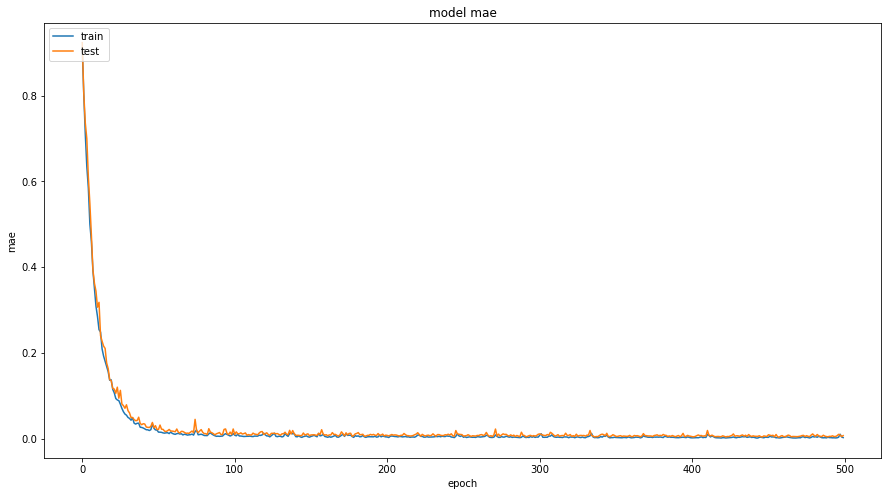

In [34]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

prediction = NN_model.predict(train_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.6633162  -0.60244614 -0.44016406 -0.8734317  -0.65741277]
 [-0.6789609  -0.6139009  -0.44855458 -0.52793384 -0.6744615 ]
 [ 0.9231337   1.5458591   1.5833694   1.5415323   1.1126516 ]
 ...
 [ 0.66838497 -0.6376724  -0.44436428 -0.8611626  -0.6076829 ]
 [-0.5543019  -0.53763396 -0.41097146  1.5276556  -0.5462674 ]
 [-0.7293083  -0.5908861  -0.39224252  1.3117198  -0.6730747 ]]
MSE:  317.3515600433204
RMSE:  17.81436386861233
MAE:  11.992707239963545


### Save the model and the scalers

In [36]:
import joblib

model_name = "NNLowpass-StanScaled"

NN_model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/NNLowpass-StanScaled-EMG.gz']

In [37]:
# Making a prediction in the prediction script.
from keras.models import load_model
model = load_model(f"../models/{model_name}.h5")

input_scaler = joblib.load(f'../models/{model_name}-EMG.gz')
output_scaler = joblib.load(f'../models/{model_name}-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred

array([[-1765.5109 , -4874.8423 ,  -128.47276,  3104.5588 ,  2081.0432 ]],
      dtype=float32)

## RNN

LSTM layer is a recurrent layer, hence it expects a 3-dimensional input (batch_size, timesteps, input_dim).

For some reason, using LSTMs gave me a: CuDNNLSTM: UnknownError: Fail to find the dnn implementation.
Which was solved enabling memory growth with:
```
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
```
Found on stackoverflow [here](https://stackoverflow.com/questions/54473254/cudnnlstm-unknownerror-fail-to-find-the-dnn-implementation).

In [38]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import LSTM

In [39]:
y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df[y_cols]
X = df[x_cols]

In [40]:
def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X)

In [41]:
Xs.shape

(2299, 16)

In [42]:
rel_hand_scaler = MinMaxScaler()
emg_scaler = MinMaxScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(Xs)

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]
timesteps = 2

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

In [43]:
ny.shape, nX.shape

((2299, 5), (2299, 8, 2))

In [44]:
ny

array([[0.65786904, 0.6627566 , 0.7605083 , 0.797654  , 0.6744868 ],
       [0.6686217 , 0.7028348 , 0.82111436, 0.8191593 , 0.7096774 ],
       [0.6783969 , 0.72825027, 0.8758553 , 0.8514174 , 0.740958  ],
       ...,
       [0.43890518, 0.12316716, 0.        , 0.07331378, 0.01466276],
       [0.43890518, 0.12316716, 0.        , 0.07331378, 0.01466276],
       [0.43890518, 0.1260997 , 0.        , 0.07331378, 0.01466276]],
      dtype=float32)

In [45]:
rel_hand_scaler.transform(y)

array([[0.65493646, 0.62658847, 0.72727273, 0.78005865, 0.64613881],
       [0.65786901, 0.6627566 , 0.76050831, 0.79765396, 0.6744868 ],
       [0.6686217 , 0.7028348 , 0.82111437, 0.81915934, 0.70967742],
       ...,
       [0.43890518, 0.12316716, 0.        , 0.07331378, 0.01466276],
       [0.43890518, 0.12316716, 0.        , 0.07331378, 0.01466276],
       [0.43890518, 0.12609971, 0.        , 0.07331378, 0.01466276]])

In [46]:
y.head()

,Thumb,Index,Middle,Ring,Pinky
250,670,641,744,798,661
251,673,678,778,816,690
252,684,719,840,838,726
253,694,745,896,871,758
254,698,752,919,878,770


In [47]:
Xs

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_1_p1,Channel_2_p1,Channel_3_p1,Channel_4_p1,Channel_5_p1,Channel_6_p1,Channel_7_p1,Channel_8_p1
251,0.000001,0.000001,0.000006,9.154731e-07,7.389106e-07,3.694553e-07,0.000001,0.000001,8.828125e-08,1.177083e-07,4.708333e-07,5.885417e-08,5.885417e-08,2.942708e-08,8.828125e-08,8.828125e-08
252,0.000006,0.000009,0.000038,7.211643e-06,4.641786e-06,2.350320e-06,0.000007,0.000006,1.020085e-06,1.448394e-06,5.940712e-06,9.154731e-07,7.389106e-07,3.694553e-07,1.078939e-06,1.049512e-06
253,0.000023,0.000037,0.000162,3.780580e-05,1.971182e-05,1.024008e-05,0.000027,0.000025,5.913168e-06,8.884690e-06,3.770974e-05,7.211643e-06,4.641786e-06,2.350320e-06,6.593224e-06,6.223769e-06
254,0.000071,0.000116,0.000530,1.477893e-04,6.442253e-05,3.468746e-05,0.000087,0.000077,2.327039e-05,3.667443e-05,1.616600e-04,3.780580e-05,1.971182e-05,1.024008e-05,2.729097e-05,2.491123e-05
255,0.000180,0.000305,0.001428,4.613184e-04,1.743919e-04,9.779871e-05,0.000232,0.000196,7.085778e-05,1.161206e-04,5.301159e-04,1.477893e-04,6.442253e-05,3.468746e-05,8.722907e-05,7.673725e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,1.319256,3.787512,12.782541,6.430441e+00,2.554882e+00,1.875008e+00,1.531158,1.362015,1.304719e+00,3.777116e+00,1.275608e+01,6.558716e+00,2.542530e+00,1.825791e+00,1.532207e+00,1.343542e+00
2546,1.334558,3.799884,12.791173,6.303184e+00,2.571441e+00,1.925400e+00,1.529819,1.378506,1.319256e+00,3.787512e+00,1.278254e+01,6.430441e+00,2.554882e+00,1.875008e+00,1.531158e+00,1.362015e+00
2547,1.350638,3.814518,12.781884,6.177428e+00,2.592233e+00,1.976371e+00,1.528198,1.392890,1.334558e+00,3.799884e+00,1.279117e+01,6.303184e+00,2.571441e+00,1.925400e+00,1.529819e+00,1.378506e+00
2548,1.367489,3.831665,12.754899,6.053697e+00,2.617209e+00,2.027323e+00,1.526288,1.405064,1.350638e+00,3.814518e+00,1.278188e+01,6.177428e+00,2.592233e+00,1.976371e+00,1.528198e+00,1.392890e+00


In [48]:
df_rel.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
250,3,4,16,2,2,1,3,3,670,641,744,798,661
251,0,3,17,8,2,1,2,1,673,678,778,816,690
252,2,2,24,20,2,2,2,1,684,719,840,838,726
253,1,2,0,12,3,3,5,2,694,745,896,871,758
254,2,8,16,5,3,2,1,1,698,752,919,878,770


In [49]:
train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [50]:
train_X.shape, train_y.shape

((1799, 8, 2), (1799, 5))

## Simple RNN Arc

In [53]:
model = Sequential()
# 8 Features and 2 timesteps
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))

model.compile(loss='mse', optimizer='adam')

In [54]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
25/25 - 3s - loss: 0.0787 - val_loss: 0.1612
Epoch 2/50
25/25 - 0s - loss: 0.0854 - val_loss: 0.1652
Epoch 3/50
25/25 - 0s - loss: 0.0731 - val_loss: 0.1574
Epoch 4/50
25/25 - 0s - loss: 0.0745 - val_loss: 0.1557
Epoch 5/50
25/25 - 0s - loss: 0.0733 - val_loss: 0.1538
Epoch 6/50
25/25 - 0s - loss: 0.0726 - val_loss: 0.1519
Epoch 7/50
25/25 - 0s - loss: 0.0720 - val_loss: 0.1501
Epoch 8/50
25/25 - 0s - loss: 0.0714 - val_loss: 0.1482
Epoch 9/50
25/25 - 0s - loss: 0.0709 - val_loss: 0.1464
Epoch 10/50
25/25 - 0s - loss: 0.0703 - val_loss: 0.1446
Epoch 11/50
25/25 - 0s - loss: 0.0698 - val_loss: 0.1428
Epoch 12/50
25/25 - 0s - loss: 0.0693 - val_loss: 0.1412
Epoch 13/50
25/25 - 0s - loss: 0.0688 - val_loss: 0.1397
Epoch 14/50
25/25 - 0s - loss: 0.0684 - val_loss: 0.1386
Epoch 15/50
25/25 - 0s - loss: 0.0681 - val_loss: 0.1379
Epoch 16/50
25/25 - 0s - loss: 0.0679 - val_loss: 0.1374
Epoch 17/50
25/25 - 0s - loss: 0.0677 - val_loss: 0.1369
Epoch 18/50
25/25 - 0s - loss: 0.0675 - 

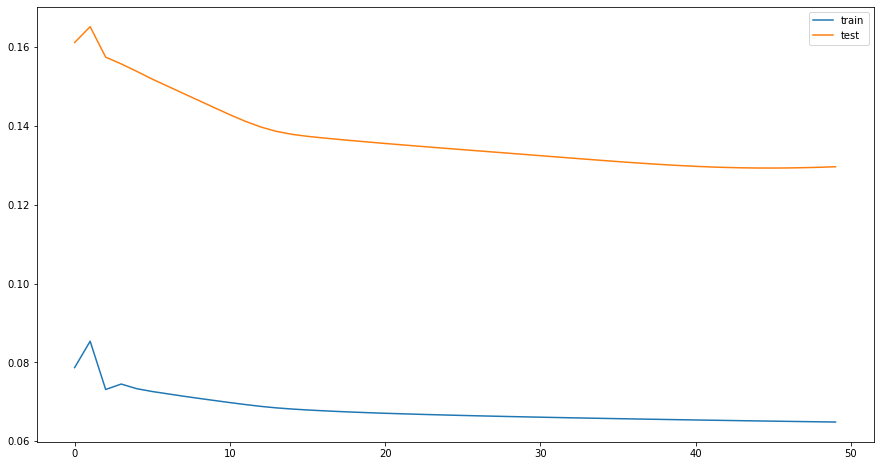

In [55]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [56]:
mea = model.evaluate(test_X, test_y)
mea

16/16 [==============================] - 0s 2ms/step - loss: 0.1296


0.12963560223579407

# Non Trivial RNN Arc

In [57]:
model = Sequential()
# 8 Features and 2 timesteps
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(14))
model.add(Dense(5))

model.compile(loss='mse', optimizer='Adam', metrics=['mae', 'mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8, 50)             10600     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 14)                714       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 75        
Total params: 31,589
Trainable params: 31,589
Non-trainable params: 0
_________________________________________________________________


In [58]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=False)

Epoch 1/50
25/25 [==============================] - 3s 32ms/step - loss: 0.0549 - mae: 0.1259 - mse: 0.0549 - val_loss: 0.1655 - val_mae: 0.3292 - val_mse: 0.1655
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0744 - mae: 0.2159 - mse: 0.0744 - val_loss: 0.1683 - val_mae: 0.2805 - val_mse: 0.1683
Epoch 3/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0428 - mae: 0.1436 - mse: 0.0428 - val_loss: 0.1505 - val_mae: 0.3001 - val_mse: 0.1505
Epoch 4/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0511 - mae: 0.1844 - mse: 0.0511 - val_loss: 0.1514 - val_mae: 0.2918 - val_mse: 0.1514
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0466 - mae: 0.1699 - mse: 0.0466 - val_loss: 0.1477 - val_mae: 0.2927 - val_mse: 0.1477
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0476 - mae: 0.1753 - mse: 0.0476 - val_loss: 0.1462 - val_mae: 0.2905 - val_mse: 0.1462
Epoch 7/50
25/25 [=========

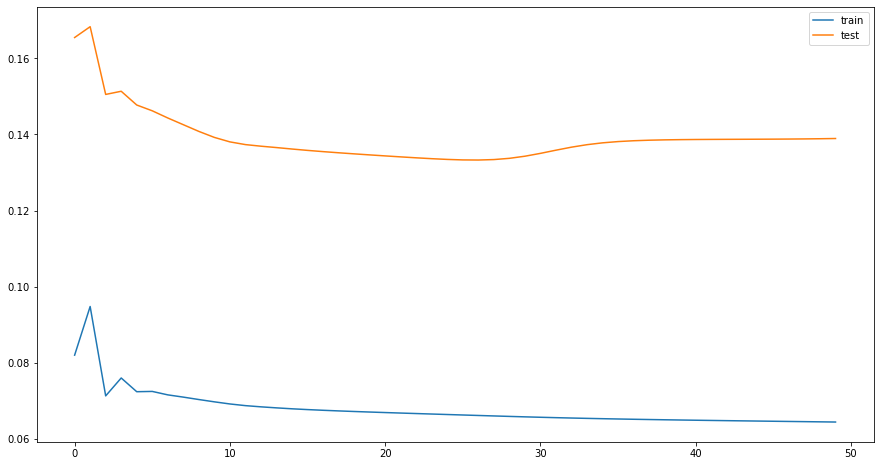

In [59]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

MAE still performs better as a loss than MSE

Results of minimising MSE loss

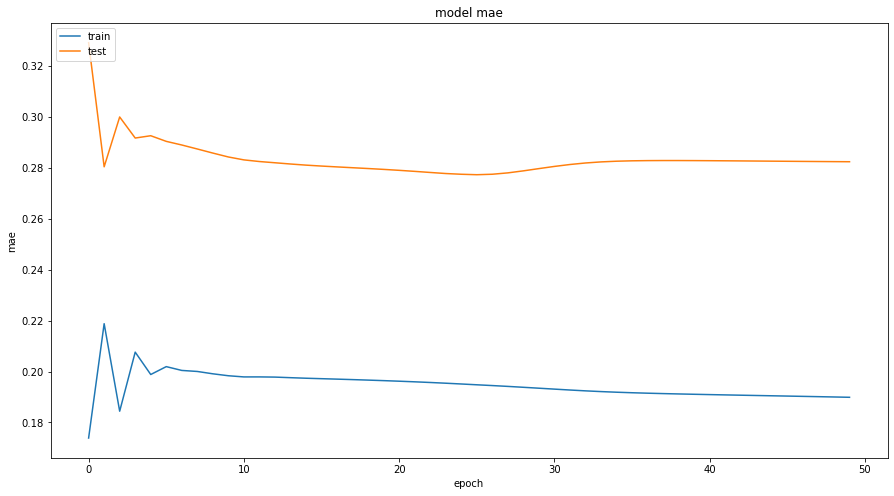

In [60]:
# summarize history for loss
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
def get_metrics(model, y_scaler, scaled_X, scaled_y):# Training Metrics
    prediction = model.predict(scaled_X) # scaled inputs here

    # Scaling back the prediction
    preds = y_scaler.inverse_transform(prediction)
    # Scaling back the goals
    goal = y_scaler.inverse_transform(scaled_y)

    MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
    print("MSE: ", MSE)
    print("RMSE: ", np.sqrt(MSE))  # 3rd step
    MAE = mean_absolute_error(goal, preds)
    print("MAE: ", MAE)

In [62]:
print("Train:")
get_metrics(model, rel_hand_scaler, train_X, train_y)
print("\nTest:")
get_metrics(model, rel_hand_scaler, test_X, test_y)

Train:
MSE:  64714.586
RMSE:  254.39061
MAE:  192.9725

Test:
MSE:  145409.9
RMSE:  381.3265
MAE:  288.9587


In [63]:
# Saving RNN Model

model_name = "RNNRel-4mins-MinMaxScaled"

model.save(f"../models/{model_name}.h5")

## Longer Timesequence RNN

In [65]:
timesteps = 20

y_cols = finger_names
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df_rel[y_cols]
X = df_rel[x_cols]

def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X, timesteps)

rel_hand_scaler = MinMaxScaler()
emg_scaler = MinMaxScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(Xs)

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [68]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(14))
model.add(Dense(5))

model.compile(loss='mae', optimizer='Adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8, 64)             21760     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 14)                462       
_________________________________________________________________
dense_13 (Dense)             (None, 5)                

In [69]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=True)


Epoch 1/50
25/25 [==============================] - 3s 31ms/step - loss: 0.1806 - val_loss: 0.2443
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1605 - val_loss: 0.2433
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1514 - val_loss: 0.2438
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1561 - val_loss: 0.2432
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1508 - val_loss: 0.2434
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1566 - val_loss: 0.2444
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1508 - val_loss: 0.2443
Epoch 8/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1486 - val_loss: 0.2436
Epoch 9/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1512 - val_loss: 0.2440
Epoch 10/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1476 - val_loss: 0.2439
Epoch 11/50
25/25 

16/16 [==============================] - 0s 3ms/step - loss: 0.2439


0.24385760724544525

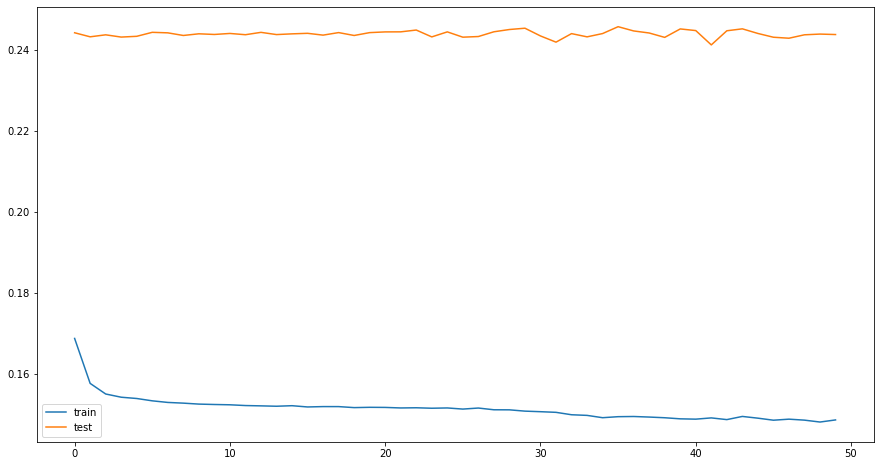

In [70]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

mse = model.evaluate(test_X, test_y)
mse


In [71]:
print("Train:")
get_metrics(model, rel_hand_scaler, train_X, train_y)
print("\nTest:")
get_metrics(model, rel_hand_scaler, test_X, test_y)

Train:
MSE:  82264.77
RMSE:  286.81836
MAE:  150.61734

Test:
MSE:  166079.9
RMSE:  407.52902
MAE:  249.46626


### 1 million parameter RNN

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import LSTM

In [52]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dense(14))
model.add(Dense(3))

model.compile(loss='mae', optimizer='Adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8, 256)            283648    
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8, 256)            525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 256)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

In [53]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=True)


Epoch 1/50
159/159 [==============================] - 1s 9ms/step - loss: 0.1826 - val_loss: 0.1535
Epoch 2/50
159/159 [==============================] - 1s 6ms/step - loss: 0.1321 - val_loss: 0.1491
Epoch 3/50
159/159 [==============================] - 1s 6ms/step - loss: 0.1298 - val_loss: 0.1383
Epoch 4/50
159/159 [==============================] - 1s 6ms/step - loss: 0.1282 - val_loss: 0.1397
Epoch 5/50
159/159 [==============================] - 1s 6ms/step - loss: 0.1267 - val_loss: 0.1195
Epoch 6/50
159/159 [==============================] - 1s 6ms/step - loss: 0.1258 - val_loss: 0.1196
Epoch 7/50
159/159 [==============================] - 1s 6ms/step - loss: 0.1244 - val_loss: 0.1205
Epoch 8/50
159/159 [==============================] - 1s 6ms/step - loss: 0.1230 - val_loss: 0.1186
Epoch 9/50
159/159 [==============================] - 1s 6ms/step - loss: 0.1224 - val_loss: 0.0947
Epoch 10/50
159/159 [==============================] - 1s 6ms/step - loss: 0.1222 - val_loss: 0.1040

16/16 [==============================] - 0s 2ms/step - loss: 0.1300


0.13001999258995056

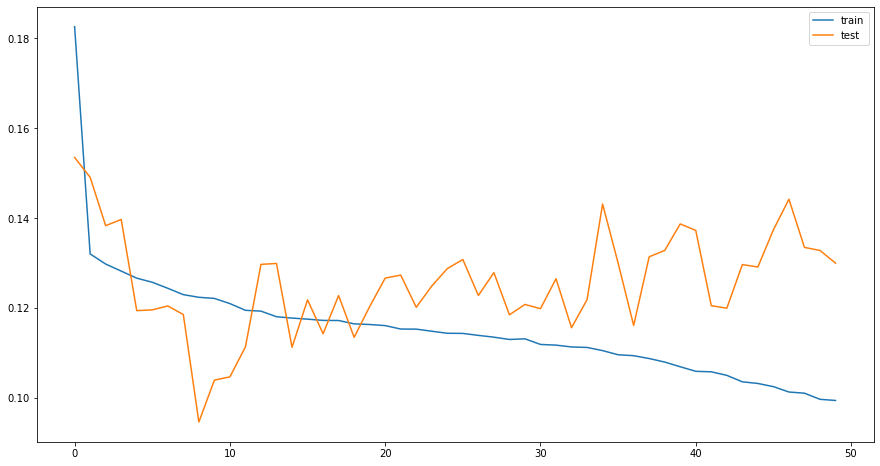

In [54]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

mea = model.evaluate(test_X, test_y)
mea


In [55]:
print("Train:")
get_metrics(model, rel_hand_scaler, train_X, train_y)
print("\nTest:")
get_metrics(model, rel_hand_scaler, test_X, test_y)

Train:
MSE:  96.85425
RMSE:  9.841455
MAE:  6.8336434

Test:
MSE:  128.12355
RMSE:  11.319167
MAE:  8.597791


Adding early stopping. 

In [56]:
from keras.callbacks import EarlyStopping
# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [57]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dense(14))
model.add(Dense(3))

model.compile(loss='mse', optimizer='Adam', metrics=['mae', 'mse'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8, 256)            283648    
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 256)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 8, 256)            525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 256)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)              

In [58]:
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), shuffle=True, callbacks=[early_stop])

Epoch 1/500
159/159 [==============================] - 2s 10ms/step - loss: 0.1593 - mae: 0.2681 - mse: 0.1593 - val_loss: 0.0390 - val_mae: 0.1569 - val_mse: 0.0390
Epoch 2/500
159/159 [==============================] - 1s 7ms/step - loss: 0.0368 - mae: 0.1502 - mse: 0.0368 - val_loss: 0.0352 - val_mae: 0.1500 - val_mse: 0.0352
Epoch 3/500
159/159 [==============================] - 1s 7ms/step - loss: 0.0317 - mae: 0.1394 - mse: 0.0317 - val_loss: 0.0320 - val_mae: 0.1387 - val_mse: 0.0320
Epoch 4/500
159/159 [==============================] - 1s 7ms/step - loss: 0.0296 - mae: 0.1349 - mse: 0.0296 - val_loss: 0.0206 - val_mae: 0.1161 - val_mse: 0.0206
Epoch 5/500
159/159 [==============================] - 1s 7ms/step - loss: 0.0291 - mae: 0.1335 - mse: 0.0291 - val_loss: 0.0210 - val_mae: 0.1136 - val_mse: 0.0210
Epoch 6/500
159/159 [==============================] - 1s 7ms/step - loss: 0.0284 - mae: 0.1318 - mse: 0.0284 - val_loss: 0.0223 - val_mae: 0.1230 - val_mse: 0.0223
Epoch 7/5

16/16 [==============================] - 0s 2ms/step - loss: 0.0229 - mae: 0.1264 - mse: 0.0229


[0.02290489338338375, 0.1263691782951355, 0.02290489338338375]

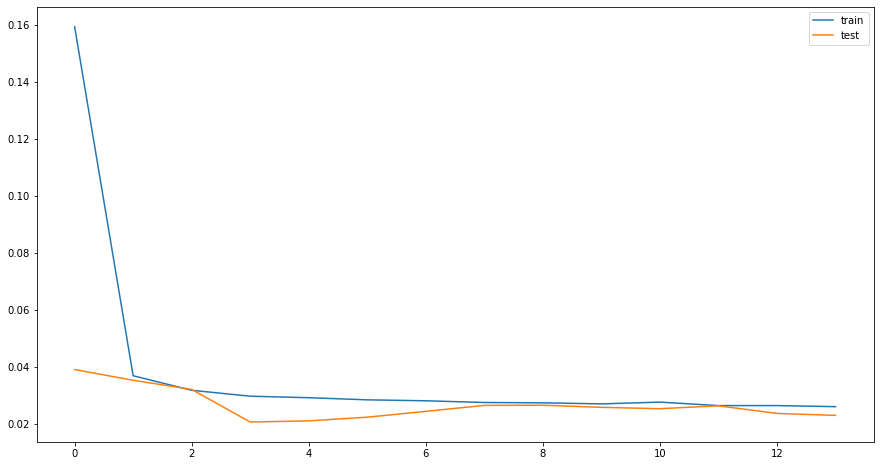

In [59]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

mse = model.evaluate(test_X, test_y)
mse


In [60]:
print("Train:")
get_metrics(model, rel_hand_scaler, train_X, train_y)
print("\nTest:")
get_metrics(model, rel_hand_scaler, test_X, test_y)

Train:
MSE:  131.13124
RMSE:  11.451255
MAE:  8.603576

Test:
MSE:  112.91575
RMSE:  10.626183
MAE:  8.48684
